#install and import required packages

In [ ]:
!pip install hazm==0.7

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.7/316.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 8.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 11.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for nltk: filename=nltk-3.3-py3-none-any.whl size=1394474 sha256=eb3d6c30ccf95c882008980aa04fd62ead88e9bf6d05fe3910c2cd4299905674
  Stored in directory: /root/.cache/pip/wheels/6b/6d/14/3defa4cd7013faeddf715150696f4a96d7725c87700eb8a68e
  Created wheel for libwapiti: filename=libwapiti-0.2.1-cp310-cp310-linux_x86_64.whl size=179247 sha256=3f81257a46001a16dfa89f261794451d9cdf2a28b1d96fa10be775b660ed244c
  Stored in directory: /root/.cache/pip/wheels/9f/cb/30/fef48ecac051e433987eccdb5682900b4c00d44a4bcd4d4ec8
Successfully built nltk libwapiti
  Attempting uninstall: nltk
    Found existing installation: nltk 3.8.1
    Uninstalling nltk-3.8.1:
      Succ

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hazm
import string

from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, cross_val_score
from hazm import WordTokenizer, Normalizer, Stemmer, stopwords_list, Lemmatizer
#pip show hazm
#Version: 0.9.3

#import data directly from kaggle

In [ ]:
# Make sure the kaggle.json is present.
!ls -lha kaggle.json

# Install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

# Replace with your dataset's API command
!kaggle datasets download -d soheiltehranipour/snappfood-persian-sentiment-analysis

!unzip snappfood-persian-sentiment-analysis.zip

-rw-r--r-- 1 root root 67 Oct 18 14:11 kaggle.json
  0% 0.00/3.16M [00:00<?, ?B/s]
100% 3.16M/3.16M [00:00<00:00, 129MB/s]
Archive:  snappfood-persian-sentiment-analysis.zip
  inflating: Snappfood - Sentiment Analysis.csv  


#data exploration



In [ ]:
df = pd.read_csv('Snappfood - Sentiment Analysis.csv', delimiter='\t')
print('shape of dataset: ', df.shape, '\n', '-------------')
print(df.info())

shape of dataset:  (70000, 4) 
 -------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  520 non-null    object 
 1   comment     70000 non-null  object 
 2   label       70000 non-null  object 
 3   label_id    69480 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.1+ MB
None


In [ ]:
df.head(3)

,Unnamed: 0,comment,label,label_id
0,NaN,واقعا حیف وقت که بنویسم سرویس دهیتون شده افتضاح,SAD,1.0
1,NaN,قرار بود ۱ ساعته برسه ولی نیم ساعت زودتر از مو...,HAPPY,0.0
2,NaN,قیمت این مدل اصلا با کیفیتش سازگاری نداره، فقط...,SAD,1.0


In [ ]:
df.drop(df.columns[0], axis=1, inplace=True)
df.sample(3)

,comment,label,label_id
68053,بارن واسه همه بامیه هات مرسی,HAPPY,0.0
64461,سفارش بعد از تقریبا دو ساعت و چند بار پیگیری ت...,SAD,1.0
8390,غذاشون خیلی خوشمزه بود و پر و پیمون و زود اماد...,HAPPY,0.0


In [ ]:
df.isnull().sum()

comment       0
label         0
label_id    520
dtype: int64

In [ ]:
df[df['label_id'].isnull()].head(3)

,comment,label,label_id
21,SAD,1,NaN
89,SAD,1,NaN
161,SAD,1,NaN


In [ ]:
df.dropna(axis=0, inplace=True)
df.isnull().sum()

comment     0
label       0
label_id    0
dtype: int64

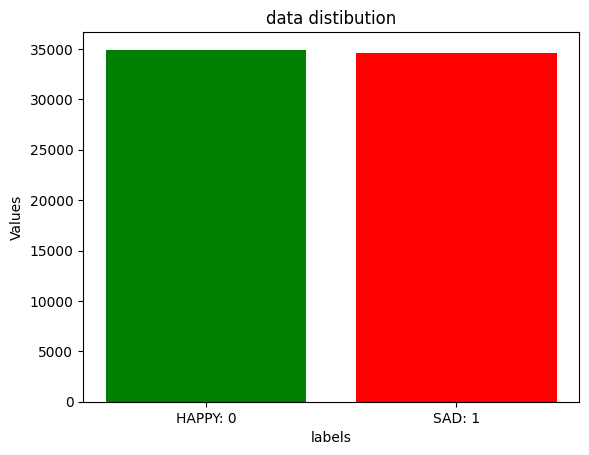

In [ ]:
count_label = list(df['label_id'].value_counts())

colors = ['green', 'red']
plt.bar([0, 1], count_label, color= colors)

# Customize the tick markers or labels on the horizontal axis
new_labels = ['HAPPY: 0', 'SAD: 1']
plt.xticks([0, 1], new_labels)

# Add labels and title to the plot
plt.xlabel('labels')
plt.ylabel('Values')
plt.title('data distibution')

plt.show()


In [ ]:
df['words_count'] = df['comment'].apply(lambda t: len(hazm.word_tokenize(t)))

min_max_len = df['words_count'].min() , df['words_count'].max()
print(f'Text Min: {min_max_len[0]} \tMax: {min_max_len[1]}')

Text Min: 2 	Max: 378


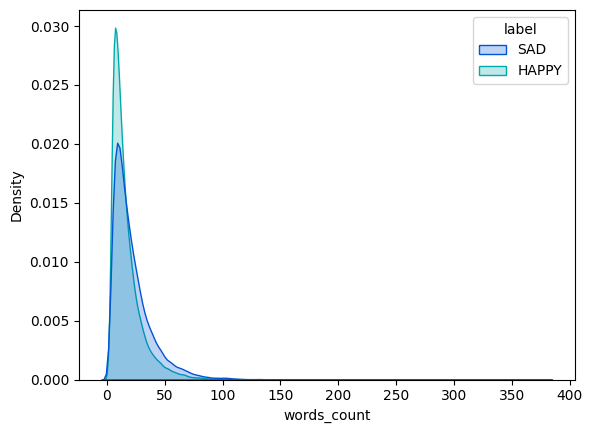

In [ ]:
sns.kdeplot(x = df['words_count'], hue=df['label'], palette='winter', fill=True, warn_singular=False)
plt.show()

#data cleaning

In [ ]:
normalizer = Normalizer()
lemmatizer = Lemmatizer()
stemmer = Stemmer()
stopwords = stopwords_list()
punctuations = string.punctuation + "," + "،" + "\u200c"

def normalize_text(text):
  translator = str.maketrans('', '', punctuations)
  normalized_text = normalizer.normalize(text)
  #test: add lemmatize
  #test: add len(word)>2
  #test: apply list of stopwords in github
  #cleaned_text = [stemmer.stem(word.translate(translator)) for word in hazm.word_tokenize(normalized_text) if word not in stopwords]
  #update_cleaned_text = [word for word in cleaned_text if len(word)>2]
  cleaned_text = [stemmer.stem(word.translate(translator)) for word in hazm.word_tokenize(normalized_text)]

  return ' '.join(cleaned_text)
  #return update_cleaned_text.replace('#', ' ')


In [ ]:
df['comment'].apply(normalize_text)

0            واقعا حیف وق که بنویس سرویس دهیتون شده افتضاح
1        قرار بود ۱ ساعته برسه ول ن ساع زود از موقع رسی...
2        قیم این مدل اصلا با کیفیت سازگار نداره  فقط ظا...
3        عاللل بود همه چه درس و به اندازه و کیف خوب  ام...
4                              شیرین وانیل فقط یک مدل بود 
                               ...                        
69995    سلا من به فاکتور غذا که سفار مید احتیاج دار و ...
69996        سایز پیتزا نسب به سفارشات که قبلا گذ ک شدهبود
69997    من قارچ اضافه رو اضافه کردهبود بود اما اگر همی...
69998       همرو بعد ۲ساع تاخیر اشتباه آوردن پول رف رو هوا
69999                                 فلفل خییییل تند بود 
Name: comment, Length: 69480, dtype: object

In [ ]:
from collections import Counter

all_text = ' '.join(df['comment'])
tokens = hazm.word_tokenize(all_text)
word_counts = Counter(tokens)
min_freq = 5 # set a minimum frequency threshold
filtered_words = [word for word, count in word_counts.items() if count >= min_freq]
unique_words = set(filtered_words)
#unique_words = set(tokens)
number_of_unique_words = len(unique_words)
print('number of unique words : ', number_of_unique_words)

number of unique words :  8263


In [ ]:
pip install transformers

from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

max_len = 50

tokenizer = Tokenizer(num_words=number_of_unique_words, lower=False)
tokenizer.fit_on_texts(df['comment'])

train_sequences = tokenizer.texts_to_sequences(df['comment'])
train_sequences_matrix = pad_sequences(
    train_sequences, maxlen=max_len, padding='post', truncating='post')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_sequences_matrix, df['label_id'], test_size=0.1, random_state=42)

In [ ]:
from keras.layers import Dense , LSTM, Embedding, Dropout , Bidirectional
from keras.models import Sequential
from keras.regularizers import l2

embedding_vecor_length = 300
model = Sequential()
model.add(Embedding(number_of_unique_words, embedding_vecor_length, input_length=max_len))
model.add(Bidirectional(LSTM(50, dropout=0.3,kernel_regularizer=l2(0.01))))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 300)           2478900   
                                                                 
 bidirectional (Bidirection  (None, 100)               140400    
 al)                                                             
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 2619401 (9.99 MB)
Trainable params: 2619401 (9.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(
    monitor='val_accuracy', patience=3, verbose=0, mode='max', restore_best_weights=False)
model_ckpt = ModelCheckpoint(filepath='/content/weights.{epoch:02d}.hdf5')
callbacks = [early_stopping, model_ckpt]


history = model.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
196/196 [==============================] - 45s 162ms/step - loss: 1.2504 - accuracy: 0.8004 - val_loss: 0.3893 - val_accuracy: 0.8487
Epoch 2/50
  1/196 [..............................] - ETA: 3s - loss: 0.3456 - accuracy: 0.8633

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


196/196 [==============================] - 14s 73ms/step - loss: 0.3475 - accuracy: 0.8630 - val_loss: 0.3679 - val_accuracy: 0.8475
Epoch 3/50
196/196 [==============================] - 9s 47ms/step - loss: 0.3207 - accuracy: 0.8731 - val_loss: 0.3607 - val_accuracy: 0.8514
Epoch 4/50
196/196 [==============================] - 8s 39ms/step - loss: 0.3049 - accuracy: 0.8814 - val_loss: 0.3754 - val_accuracy: 0.8466
Epoch 5/50
196/196 [==============================] - 7s 38ms/step - loss: 0.2941 - accuracy: 0.8849 - val_loss: 0.3679 - val_accuracy: 0.8477
Epoch 6/50
196/196 [==============================] - 5s 24ms/step - loss: 0.2827 - accuracy: 0.8909 - val_loss: 0.3779 - val_accuracy: 0.8406


In [ ]:
y_pred = model.predict(X_test)
y_pred = [1 if p > 0.5 else 0 for p in y_pred]
print(classification_report(y_test, y_pred))

218/218 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

         0.0       0.85      0.82      0.84      3476
         1.0       0.83      0.86      0.84      3472

    accuracy                           0.84      6948
   macro avg       0.84      0.84      0.84      6948
weighted avg       0.84      0.84      0.84      6948



In [ ]:
np_error = np.array(X_test)[y_pred!=y_test]

print(len(np_error))

1108


In [ ]:
y_test_list = y_test.tolist()
y_pred_list = y_pred
mistake_indices = []


for i in range(len(y_test_list)):

    if y_test_list[i] != y_pred[i]:
        mistake_indices.append(i)

print("Indices of rows with mistakes during training:", mistake_indices)

In [ ]:
y_pred[3]

0

In [ ]:
for i in mistake_indices:
  print(tokenizer.sequences_to_texts([X_test[i]]), 'y_test:', np.array(y_test)[i], 'y_pred:', y_pred[i], '\n', '---------------------------')


['با سلام سابق بر این بسته بندی از کیفیت بهتری برخوردار بود ولی در حال حاضر وجود داره به طور نمونه نوشابه قوطی فاقد نی هست، چنگال برای سرو سیب زمینی نداره، دستمال کاغذی هم در بسته بندی نیست'] y_test: 1.0 y_pred: 0 
 ---------------------------
['مواد پیتزا بسیااار کم بود با اینکه قیمت اصلا پایین نیست ولی کلا طعم پیتزا خوب و تازه بود'] y_test: 0.0 y_pred: 1 
 ---------------------------
['درخواست آب مرغ داده بودم که در نظر گرفته نشد نسبت به قیمت لااقل باید این موارد درخواستی مشتری منظور بشه'] y_test: 0.0 y_pred: 1 
 ---------------------------
['همه چی خوب بود فقط روغن جامد علاوه بر مغایر بودن نوع روغن قیمتش هم مشخص نبود قیمت خط زده بودن'] y_test: 0.0 y_pred: 1 
 ---------------------------
['همیشه راضی بودم …اما ایندفعه پیتزا کهنه و مونده به نظر می\u200cرسید'] y_test: 1.0 y_pred: 0 
 ---------------------------
['شیرینی ناپلئونی خیلی معمولی بود و مزه ناپلئونی نداشت و شیرینی زبان خشک و بی مزه بود … که کلا شیرینی زبان رو دور من ولی لطفا کمی کیفیت رو هم بهبود بدین، ممنون'] y_test: 1.0 y_p